# Mechanistic modeling of VMHvl line attractor dynamics

By Charles Xu @ Caltech, 2024.

This notebook builds on the work by Isa in 2024 to further generalize on other plausible mechanisms of the implementation of the VMHvl line attractor.

## Environment

In [29]:
from netpyne import specs, sim, analysis
import numpy as np
import matplotlib.pyplot as plt
import random

In [30]:
## Create NetParams and SimConfig objects

# Model 1
netParams1 = specs.NetParams()
simConfig1 = specs.SimConfig()

# Model 2
netParams2 = specs.NetParams()
simConfig2 = specs.SimConfig()

## Neuron model

In [31]:
## Excitatory network

# Network parameters
N = 100
x1_percentage = 0.1
x2_percentage = 0.1
taum = 20   # ms, membrane time constant

# Number of neurons in each population
num_x1 = int(round((N / 5) * x1_percentage))
num_x2 = int(round((N / 5) * x2_percentage))
num_other = N - num_x1 - num_x2

# Create populations
HH_params = {
    'secs': {
        'soma': {
            'geom': {'diam': 18.8, 'L': 18.8},
            'mechs': {
                'hh': {'gnabar': 0.12, 'gkbar': 0.036, 'gl': 0.003, 'el': -54.3}
            }
        }
    }
}
netParams1.cellParams['hh'] = HH_params

In [32]:
# Add populations to netParams for model 1
netParams1.popParams['x1'] = {'cellType': 'hh', 'numCells': num_x1}
netParams1.popParams['x2'] = {'cellType': 'hh', 'numCells': num_x2}
netParams1.popParams['other'] = {'cellType': 'hh', 'numCells': num_other}

In [33]:
netParams1.popParams

{x1: {'cellType': 'hh', 'numCells': 2}, x2: {'cellType': 'hh', 'numCells': 2}, other: {'cellType': 'hh', 'numCells': 96}}

## Network topology

In this section, we will specify the network connectivity by defining `netParams.connParams` parameters.

In [34]:
## Define synaptic mechanism

taus = 30   # ms, synaptic time constant
netParams1.synMechParams['exc'] = {'mod': 'ExpSyn', 'tau': taus, 'e': 0}
# netParams1.synMechParams['exc'] = {'mod': 'Exp2Syn', 'tau1': 0.1, 'tau2': 5.0, 'e': 0}

In [35]:
## Initialize random connectivity

# General connectivity parameters
prob_conn = 0.01  # Sparse connectivity
weight = 0.9
delay = 1.0

# Connect neurons randomly with specified probability
netParams1.connParams['randConnect'] = {
    'preConds': {'pop': ['x1', 'x2', 'other']},
    'postConds': {'pop': ['x1', 'x2', 'other']},
    'synMech': 'exc',
    'weight': weight,
    'delay': delay,
    'probability': prob_conn
}

In [36]:
## Subnetwork connectivity

# Subnetwork parameters
subnetwork_percentage = 0.2
N_sub = int(round(N * subnetwork_percentage)) # Subnetwork size
prob_subnet = 0.36  # Functional connectivity identified in Vinograd*, Nair*, et al. (2024)
                    # Note that this number indicates the functional connectivity among x1 neurons originally in the paper

# Generate explicit subnetwork connectivity
subnet_conn_mat = np.random.choice([0, 1], size=(N_sub, N_sub), p=[1 - prob_subnet, prob_subnet])
subnet_conn_list = list(zip(*tuple(i * 5 for i in np.nonzero(subnet_conn_mat))))

# # Connect neurons within the subnetwork
# netParams1.connParams['subnetConnect'] = {
#     'preConds': {'pop': ['x1', 'x2', 'other']},    # 
#     'postConds': {'pop': ['x1', 'x2', 'other']},   # Change to 'x1' assuming x1 neurons form the subnetwork
#     'sec': 'soma',
#     'synMech': 'exc',
#     'weight': weight,
#     'delay': delay,
#     'connList': subnet_conn_list
# }

## Stimulation

In [37]:
# Input parameters
t_on = 2.5 * 1e3    # Convert to ms
t_dur = 2.0 * 1e3   # 2 s duration
t_interval = 20.0 * 1e3  # 20 s interval with 2 s pulse
n_pulses = 4

for i in range(n_pulses):
    t_start = t_on + i * (t_interval + t_dur)
    netParams1.stimSourceParams['pulse' + str(i)] = {
        'type': 'IClamp',
        'del': t_start,
        'dur': 2000,
        'amp': 1
    }

In [38]:
# Generate stimulation connections
stim_prob = 0.2 # Probability of stimulation connections
stim_conn_sample = random.sample(range(N), round(stim_prob * N))
stim_conn_sample.sort()

for i in range(n_pulses):
    netParams1.stimTargetParams['pulse' + str(i) + '->network'] = {
        'source': 'pulse' + str(i),
        'sec':'soma', 
        'loc': 0.5,
        'conds': {'pop': ['x1', 'x2', 'other'], 'cellList': stim_conn_sample}
    }

## Simulation

In [39]:

# Simulation options
simConfig1.duration = 1*1e3          # Duration of the simulation, in ms
simConfig1.dt = 0.025                # Internal integration timestep to use
simConfig1.verbose = False           # Show detailed messages
simConfig1.recordTraces = {'V_soma':{'sec':'soma','loc':0.5,'var':'v'}}  # Dict with traces to record
simConfig1.recordStep = 0.1          # Step size in ms to save data (eg. V traces, LFP, etc)
simConfig1.filename = 'tut6'         # Set file output name
simConfig1.savePickle = False        # Save params, network and sim output to pickle file

simConfig1.analysis['plotRaster'] = {'saveFig': True, 'orderBy': 'y', 'orderInverse': True}                                 # Plot a raster
simConfig1.analysis['plotTraces'] = {'include': [('S',0), ('M',0)], 'saveFig': True}  # Plot recorded traces for this list of cells

%matplotlib inline
# Create network and run simulation
sim.createSimulateAnalyze(netParams = netParams1, simConfig = simConfig1)


Start time:  2024-09-24 17:36:07.661918

Creating network of 3 cell populations on 1 hosts...
  Number of cells on node 0: 100 
  Done; cell creation time = 0.00 s.
Making connections...
  Number of connections on node 0: 89 
  Done; cell connection time = 0.02 s.
Adding stims...
  Number of stims on node 0: 80 
  Done; cell stims creation time = 0.00 s.
Recording 0 traces of 0 types on node 0

Running simulation using NEURON for 1000.0 ms...
  Done; run time = 0.43 s; real-time ratio: 2.33.

Gathering data...
  Done; gather time = 0.00 s.

Analyzing...
  Cells: 100
  Connections: 89 (0.89 per cell)
  Spikes: 100 (1.00 Hz)
  Simulated time: 1.0 s; 1 workers
  Run time: 0.43 s
Preparing spike data...
Plotting raster...
Plotting recorded cell traces ... cell


<Figure size 640x480 with 0 Axes>

  Done; plotting time = 0.08 s

Total time = 0.54 s


In [40]:
# # Simulation parameters
# simConfig1.duration = 200 * 1e3  # Simulation time in ms
# simConfig1.dt = 0.001 * 1e3      # Timestep in ms
# # simConfig1.verbose = True

# # Recording options
# # simConfig1.recordCells = [0, 50, 100, 150, 200]
# simConfig1.recordTraces = {
#     'V_soma':{'sec':'soma','loc':0.5,'var':'v'}
#     # 'spikes': {'conds': {'pop': ['x1', 'x2']}}
# }
# simConfig1.recordStep = 0.1  # Step size in ms

# # Save options
# simConfig1.filename = 'hypothalamic_sim'  # Set filename
# simConfig1.saveJson = True  # Save to JSON for analysis

# # Analysis and plotting
# simConfig1.analysis['plotRaster'] = {'orderBy': 'pop', 'popRates': True}
# simConfig1.analysis['plotTraces'] = {'include': [('x1', 0), ('x2', 0)]}
# # simConfig1.analysis['plotSpikeStats'] = {'stats': ['rate', 'isicv', 'sync']}

In [41]:
# Set a random seed for reproducibility if needed
# simConfig1.hParams['randseed'] = 1

In [42]:
# Create network and run simulation
# sim.createSimulateAnalyze(netParams=netParams1, simConfig=simConfig1)

## Analysis

Preparing spike data...
Plotting raster...


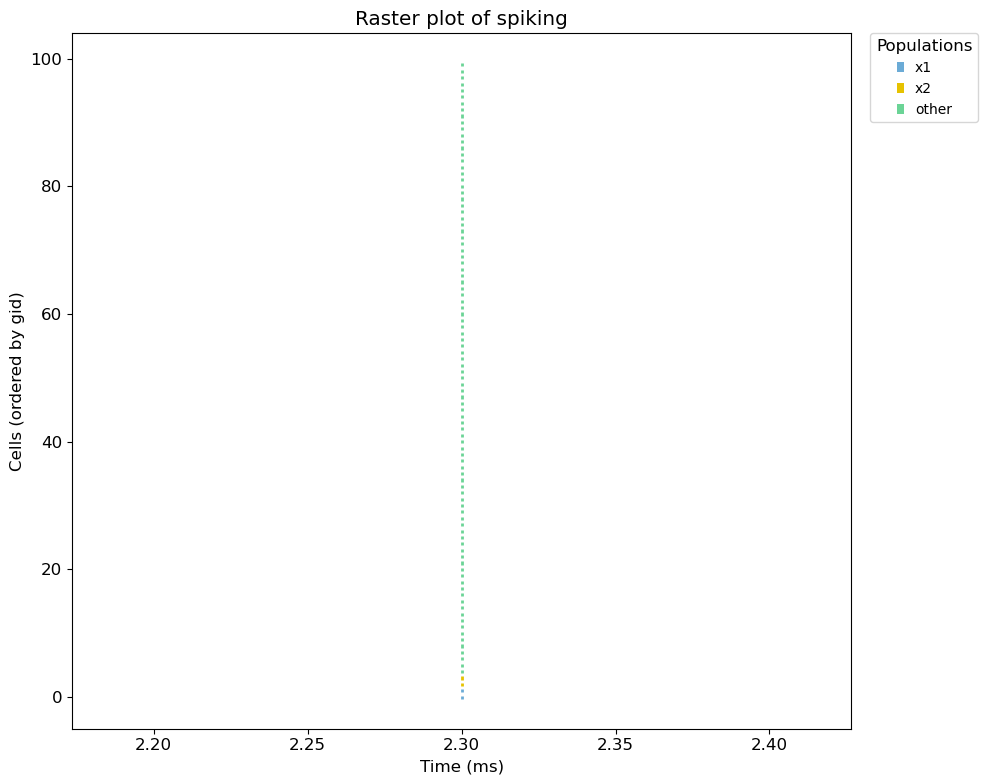

In [43]:
analysis.plotRaster()

Preparing spike data...
Plotting spike frequency...


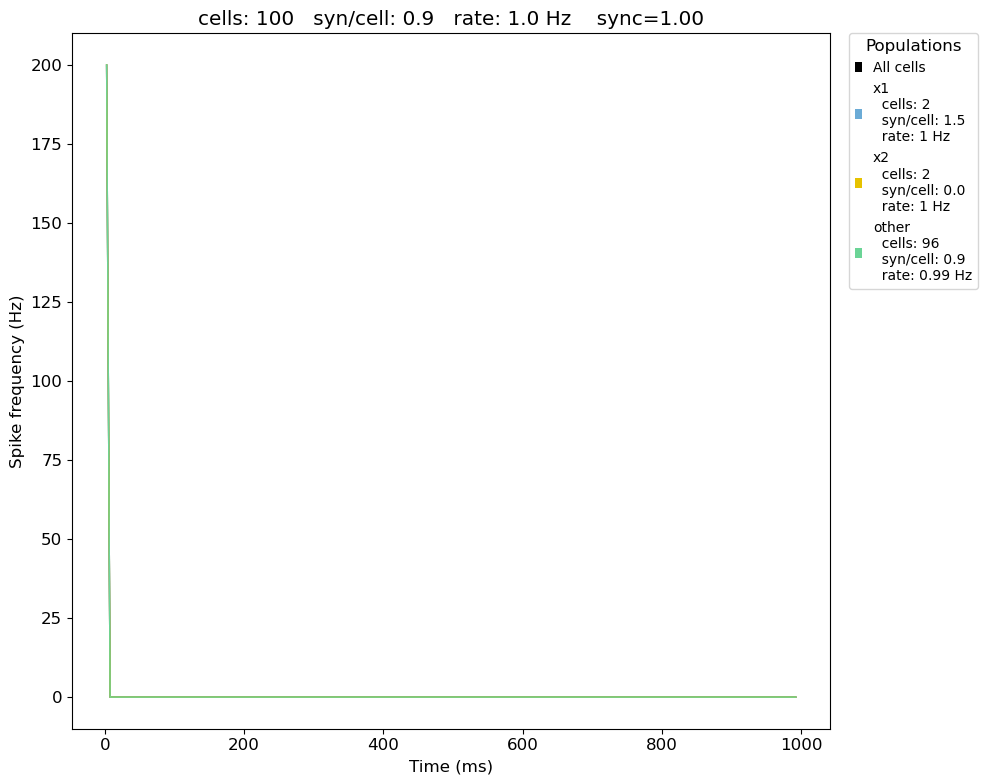

In [44]:
analysis.plotSpikeHist()

Plotting firing rate power spectral density (PSD) ...


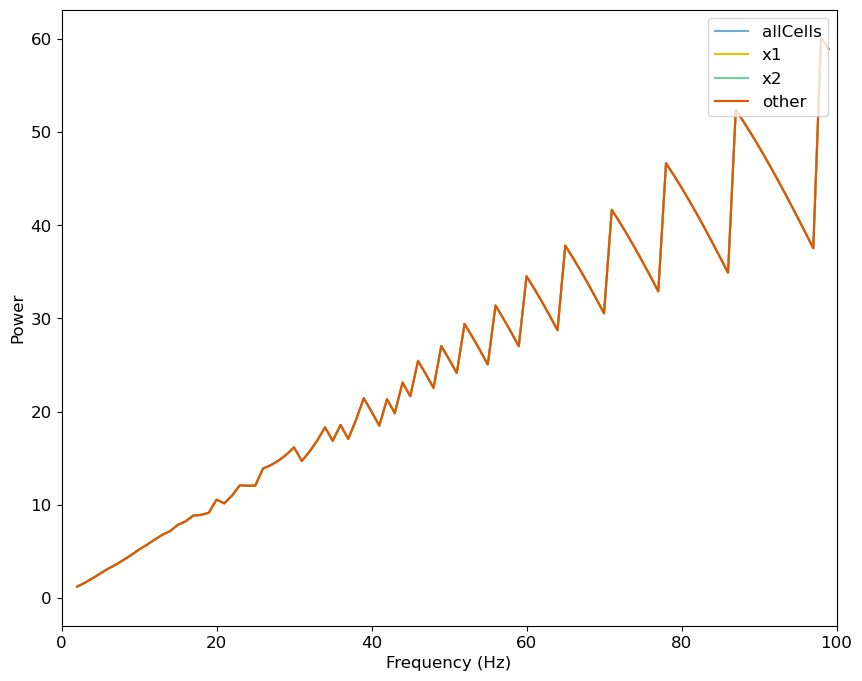

(<Figure size 1000x800 with 1 Axes>,
 {'allSignal': [array([ 0.80704567,  1.18443065,  1.6010853 ,  2.09080192,  2.59840147,
           3.10832226,  3.55004659,  4.05542494,  4.58651785,  5.17600513,
           5.67230711,  6.2268492 ,  6.75628744,  7.14696838,  7.82305174,
           8.19877057,  8.81441918,  8.89704018,  9.12374614, 10.53531013,
          10.13050675, 10.97136518, 12.07746389, 12.02391237, 12.04840346,
          13.87461074, 14.23589305, 14.72574443, 15.3594382 , 16.15180976,
          14.6908523 , 15.68868692, 16.88698344, 18.29857092, 16.84436596,
          18.55401849, 17.05618145, 19.10108417, 21.42434479, 20.00240973,
          18.48075578, 21.31926859, 19.81254229, 23.11202104, 21.6414472 ,
          25.43673191, 24.03062301, 22.53399379, 27.03243065, 25.62536738,
          24.1325443 , 29.40384874, 28.03377698, 26.57613846, 25.04743568,
          31.38473572, 30.0035868 , 28.54174615, 27.01360679, 34.52805206,
          33.18898476, 31.76860654, 30.27859633, 2

In [45]:
analysis.plotRatePSD()

In [46]:
analysis.plotTraces(include=[0, 50, 100, 150, 200])

Plotting recorded cell traces ... cell


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

({'_gid_0': <Figure size 1000x800 with 0 Axes>,
  '_gid_50': <Figure size 1000x800 with 0 Axes>},
 {'tracesData': [], 'include': [0, 50, 100, 150, 200]})